1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
# !wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [15]:
import pandas as pd

N = 10001
file_name = './data/data_000637.txt'
df = pd.read_csv(file_name)
data = df[:N]
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
9996,1,0,60,3869200267,701,5
9997,1,0,59,3869200267,707,23
9998,1,0,63,3869200267,706,15
9999,1,0,49,3869200267,777,13


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [16]:
x = df['BX_COUNTER'].max()
x

3563

3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [17]:
df['ABSOLUTE_TIME_ns'] = df['ORBIT_CNT']*25*x + df['BX_COUNTER']*25 + df['TDC_MEAS']*(25/30)

tseries = pd.Series(df['ABSOLUTE_TIME_ns'])
tseries

0          3.446490e+14
1          3.446490e+14
2          3.446490e+14
3          3.446490e+14
4          3.446490e+14
               ...     
1310715    3.446500e+14
1310716    3.446500e+14
1310717    3.446500e+14
1310718    3.446500e+14
1310719    3.446500e+14
Name: ABSOLUTE_TIME_ns, Length: 1310720, dtype: float64

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [18]:
df['Absolute_time'] = pd.to_datetime(df['ABSOLUTE_TIME_ns'], unit ='ns')
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME_ns,Absolute_time
0,1,0,123,3869200167,2374,26,3.446490e+14,1970-01-04 23:44:09.004934896
1,1,0,124,3869200167,2374,27,3.446490e+14,1970-01-04 23:44:09.004934897
2,1,0,63,3869200167,2553,28,3.446490e+14,1970-01-04 23:44:09.004939373
3,1,0,64,3869200167,2558,19,3.446490e+14,1970-01-04 23:44:09.004939490
4,1,0,64,3869200167,2760,25,3.446490e+14,1970-01-04 23:44:09.004944545
...,...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3.446500e+14,1970-01-04 23:44:09.985075886
1310716,1,1,4,3869211171,763,11,3.446500e+14,1970-01-04 23:44:09.985075909
1310717,1,0,64,3869211171,764,0,3.446500e+14,1970-01-04 23:44:09.985075925
1310718,1,0,139,3869211171,769,0,3.446500e+14,1970-01-04 23:44:09.985076050


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [19]:
noisy_channels = df.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count().sort_values(ascending=False)

noisy_channels.iloc[:3]

TDC_CHANNEL
139    108059
64      66020
63      64642
Name: TDC_CHANNEL, dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [24]:
non_empty_orbits = len(df.groupby('ORBIT_CNT').count())
non_empty_orbits

11001

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [33]:
orbits_have_139 = df[df['TDC_CHANNEL']==139].groupby('ORBIT_CNT').count()
# unique orbits will have only one count
unique_orbits_have_139 = len(orbits_have_139[orbits_have_139.iloc[:,1] == 1])
unique_orbits_have_139

51

8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [49]:
x = df[df['FPGA']==0].groupby('TDC_CHANNEL').count()
S_0 = pd.Series(x.iloc[:,1], index=x.index, name='TDC channel for FPGA = 0')
S_0

TDC_CHANNEL
1       1215
2       1602
3       1493
4       2352
5       1432
       ...  
129        2
130       33
137       32
138       34
139    75617
Name: TDC channel for FPGA = 0, Length: 124, dtype: int64

In [95]:
y = df[df['FPGA']==1].groupby('TDC_CHANNEL').count()
S_1 = pd.Series(y.iloc[:,1], index=x.index, name='TDC channel counts for FPGA = 1', dtype='Int64')
S_1

TDC_CHANNEL
1      28438
2      32669
3      21970
4      26403
5      15003
       ...  
129       35
130       38
137       36
138       36
139    32442
Name: TDC channel counts for FPGA = 1, Length: 124, dtype: Int64

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0.5, 1.0, 'FPGA = 1')

<Figure size 1440x1440 with 0 Axes>

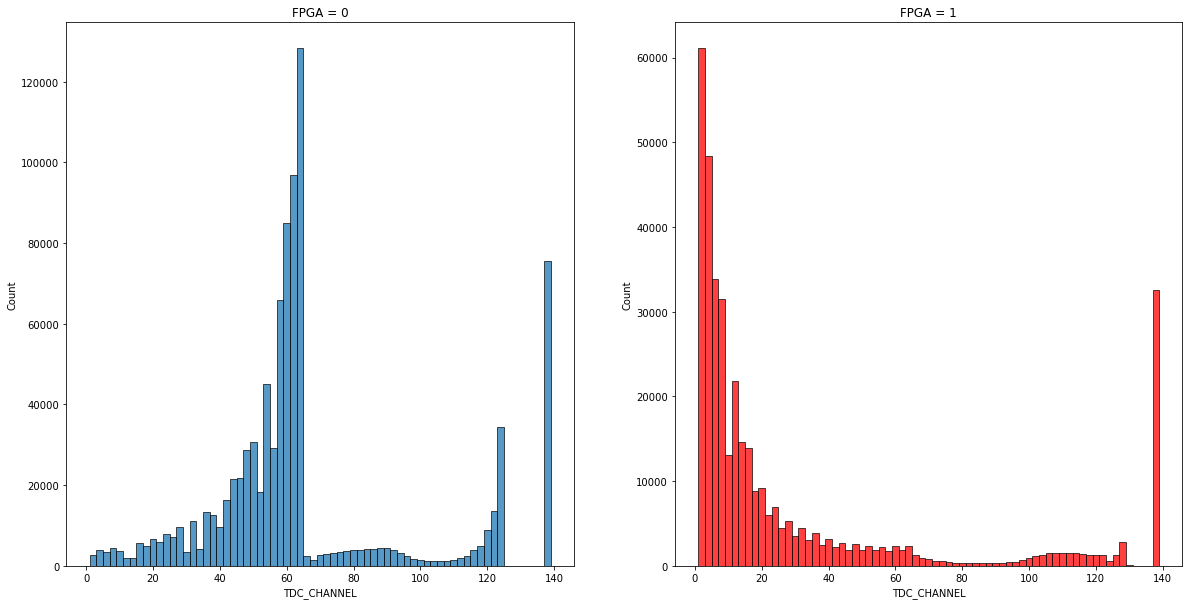

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

a = df[df['FPGA']==0]
sns.histplot(a,x=a["TDC_CHANNEL"], ax=ax1, binwidth=2)
ax1.set_title('FPGA = 0')

b = df[df['FPGA']==1]
sns.histplot(b,x=b["TDC_CHANNEL"], ax=ax2, binwidth=2, color='r')
ax2.set_title('FPGA = 1')